In [1]:
import torch
import os
import gzip
import pickle

## Load and examine dataset

In [2]:
""" Load the dataset
Code adapted from http://deeplearning.net/tutorial/code/logistic_sgd.py

:type dataset: string
:param dataset: the path to the dataset (here MNIST)
"""
# Download the MNIST dataset if it is not present
dataset = "mnist.pkl.gz"

data_dir, data_file = os.path.split(dataset)
if data_dir == "" and not os.path.isfile(dataset):
    # Check if dataset is in the data directory.
    new_path = os.path.join(
        os.path.split(__file__)[0],
        dataset
    )
    if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
        dataset = new_path

if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
    from six.moves import urllib
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

print('Loading data...')

# Load the dataset
with gzip.open(dataset, 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)
# train_set, valid_set, test_set format: tuple(input, target)
# input is a numpy.ndarray of 2 dimensions (a matrix), np.float32
# where each row corresponds to an example. target is a
# numpy.ndarray of 1 dimension (vector), np.int64 that has the same length
# as the number of rows in the input. It should give the target
# to the example with the same index in the input.
print('Loaded train_set, valid_set and test_set.')

Loading data...
Loaded train_set, valid_set and test_set.


In [3]:
print(train_set[0].shape)
print(train_set[1].shape)

# because we use lenet, we need to reshape the data
train_set = (train_set[0].reshape((-1, 1, 28, 28)), train_set[1])
valid_set = (valid_set[0].reshape((-1, 1, 28, 28)), valid_set[1])
test_set = (test_set[0].reshape((-1, 1, 28, 28)), test_set[1])

print(train_set[0].shape)
print(train_set[1].shape)

(50000, 784)
(50000,)
(50000, 1, 28, 28)
(50000,)


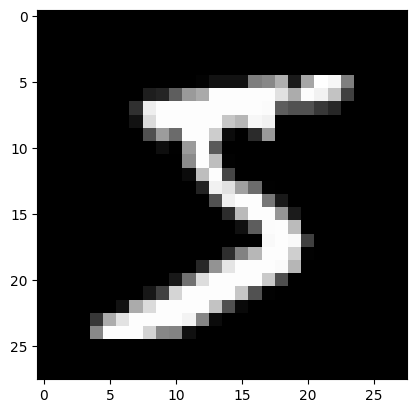

In [4]:
# plot a random sample
import matplotlib.pyplot as plt
plt.imshow(train_set[0][0][0], cmap='gray')
plt.show()

In [5]:
# Build the CNN model
import torch.nn as nn
import torch.nn.functional as F
 
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # conv2d
        self.conv1 = nn.Conv2d(1, 6, 5, bias=False)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        # bn
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        # affine
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # relu
        self.relu = nn.ReLU()
        # maxpool
        self.maxpool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # conv2d -> relu -> maxpool -> bn
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.bn2(x)
        # flatten
        x = x.view(-1, 16*4*4)
        # affine -> relu
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # affine
        x = self.fc3(x)
        return x


In [6]:
# Define the model
model = LeNet()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=1.0e-3)

# Train the model
import time
import numpy as np 

# a minibatch is 1000 samples
batch_size = 64
# number of epochs
n_epochs = 10

# convert to torch tensors
train_set = (torch.from_numpy(train_set[0]).float(), torch.from_numpy(train_set[1]).long())
valid_set = (torch.from_numpy(valid_set[0]).float(), torch.from_numpy(valid_set[1]).long())
test_set = (torch.from_numpy(test_set[0]).float(), torch.from_numpy(test_set[1]).long())

# convert to torch datasets
train_dataset = torch.utils.data.TensorDataset(train_set[0], train_set[1])
valid_dataset = torch.utils.data.TensorDataset(valid_set[0], valid_set[1])
test_dataset = torch.utils.data.TensorDataset(test_set[0], test_set[1])
 
# convert to torch dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
model = LeNet()
criterion = nn.CrossEntropyLoss()
learning_rate = 1.0e-3
n_epochs = 10

train_loss_list = []
train_acc_list = []
valid_acc_list = []
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# start time
start_time = time.time()

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch+1, n_epochs))
    
    model.eval()
    train_correct = 0
    train_total = 0 
    for data, target in train_loader:
        output = model(data)
        _, pred = torch.max(output, 1)
        train_correct += (pred == target).sum().item()
        train_total += target.size(0)
    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)
    print('Train accuracy: {:.4f}'.format(train_acc))
    
    valid_correct = 0
    valid_total = 0
    for data, target in valid_loader:
        output = model(data)
        _, pred = torch.max(output, 1)
        valid_correct += (pred == target).sum().item()
        valid_total += target.size(0)
    
    valid_acc = valid_correct / valid_total
    valid_acc_list.append(valid_acc)
    print('Validation accuracy: {:.4f}'.format(valid_acc))
    
    model.train()
    loss_sum = 0
    batch_num = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        batch_num += 1
    print("loss_sum: ", loss_sum, "batch_num: ", batch_num)
    average_loss = loss_sum / batch_num
    train_loss_list.append(average_loss)
    print('Train loss: {:.4f}'.format(average_loss))
    
# end time
end_time = time.time()
print('Total time: {:.2f} minutes'.format((end_time - start_time)/60))

Epoch 1/10
Train accuracy: 0.0901
Validation accuracy: 0.0915
loss_sum:  1753.049132347107 batch_num:  782
Train loss: 2.2418
Epoch 2/10
Train accuracy: 0.4745
Validation accuracy: 0.4783
loss_sum:  1583.8716975450516 batch_num:  782
Train loss: 2.0254
Epoch 3/10
Train accuracy: 0.6106
Validation accuracy: 0.6236
loss_sum:  1253.3108283281326 batch_num:  782
Train loss: 1.6027
Epoch 4/10
Train accuracy: 0.7446
Validation accuracy: 0.7615
loss_sum:  827.1079672574997 batch_num:  782
Train loss: 1.0577
Epoch 5/10
Train accuracy: 0.8474
Validation accuracy: 0.8646
loss_sum:  513.3284580111504 batch_num:  782
Train loss: 0.6564
Epoch 6/10
Train accuracy: 0.8932
Validation accuracy: 0.9096
loss_sum:  353.6061364412308 batch_num:  782
Train loss: 0.4522
Epoch 7/10
Train accuracy: 0.9131
Validation accuracy: 0.9240
loss_sum:  271.4709257930517 batch_num:  782
Train loss: 0.3471
Epoch 8/10
Train accuracy: 0.9249
Validation accuracy: 0.9344
loss_sum:  224.08300163596869 batch_num:  782
Train lo

In [8]:
import json
with open("results/pytorch_lenet.json", "w") as f:
    json.dump({
        "train_loss": train_loss_list,
        "train_acc": train_acc_list,
        "valid_acc": valid_acc_list
    }, f)

In [9]:
def predict(model, dataloader):
    
    # set the model to evaluation mode
    model.eval()
    
    # make predictions
    predictions = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            output = model(inputs)
            _, pred = torch.max(output, 1)
            predictions.extend(pred.cpu().numpy())
    
    return predictions


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# get some predictions
predictions = predict(model, test_loader)

# select some random samples
n_samples = 10
sample_indices = np.random.choice(len(test_set[0]), n_samples)

# plot the samples and their predicted labels
fig, axs = plt.subplots(1, n_samples, figsize=(30, 5))
for i, idx in enumerate(sample_indices):
    image = test_set[0][idx].numpy().transpose(1, 2, 0)
    label = test_set[1][idx].item()
    predicted_label = predictions[idx]
    axs[i].imshow(image)
    axs[i].set_title(f"true: {label}, predicted: {predicted_label}")
    axs[i].axis('off')
plt.show()


NameError: name 'device' is not defined